In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType

spark=SparkSession.builder.appName('FordGoBike').getOrCreate()



In [2]:
path="G:\My Drive\Develhope\Develhope_stage2\Team_3\Week_1\week_1_output.csv"
df=spark.read.csv(path,header=True, inferSchema=True)

##TASK_1 - Calculate the number of trips for each start station list top 10 and find the ratio of using as male or female - FAIZA

In [10]:
df.select(F.count(F.when(F.col('member_gender')=='Male',True)), F.count(F.when(F.col('member_gender')=='Female',True))).show()

+-----------------------------------------------------+-------------------------------------------------------+
|count(CASE WHEN (member_gender = Male) THEN true END)|count(CASE WHEN (member_gender = Female) THEN true END)|
+-----------------------------------------------------+-------------------------------------------------------+
|                                               348318|                                                  98621|
+-----------------------------------------------------+-------------------------------------------------------+



In [16]:
df3_1 = df.withColumn('F', F.when(F.col('member_gender') == 'Female', 1).otherwise(0)).withColumn('M', F.when(F.col('member_gender') == 'Male', 1).otherwise(0))

df3_1.select('F', 'M','member_gender').show(10)

+---+---+-------------+
|  F|  M|member_gender|
+---+---+-------------+
|  0|  1|         Male|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  1|  0|       Female|
|  0|  0|         null|
|  0|  0|         null|
|  0|  0|         null|
+---+---+-------------+
only showing top 10 rows



In [20]:
from pyspark.sql.functions import desc

df3_1_1 = df3_1.groupBy('start_station_id').agg({'start_station_id':'count', 'F':'sum', 'M': 'sum'}).orderBy(desc('count(start_station_id)')).limit(10)

df3_1_2 = df3_1_1.withColumn('ratio', df3_1_1[1]/df3_1_1[2])
df3_1_2.show()

+----------------+-----------------------+------+------+-----------------+
|start_station_id|count(start_station_id)|sum(F)|sum(M)|            ratio|
+----------------+-----------------------+------+------+-----------------+
|              15|                  15187|  2819|  8586|5.387371408300816|
|               6|                  13664|  1938|  7444|7.050567595459237|
|              30|                  12546|  2035|  9813|6.165110565110565|
|              67|                  12055|  2105|  9409|5.726840855106889|
|              58|                  11960|  1870|  9005| 6.39572192513369|
|              21|                  11334|  1631|  8367|6.949110974862048|
|              81|                  10956|  2302|  7773|4.759339704604692|
|               3|                  10142|  1768|  6070|5.736425339366516|
|              22|                   9926|  1980|  7512|5.013131313131313|
|              16|                   9347|  1740|  6532| 5.37183908045977|
+----------------+-------

In [21]:
df3_1_1 = df.groupBy('start_station_id').count().orderBy(desc('count')).show(10)

+----------------+-----+
|start_station_id|count|
+----------------+-----+
|              15|15187|
|               6|13664|
|              30|12546|
|              67|12055|
|              58|11960|
|              21|11334|
|              81|10956|
|               3|10142|
|              22| 9926|
|              16| 9347|
+----------------+-----+
only showing top 10 rows



##TASK_2 - Make a comparison to find the percentage of usage for customer and subscriber - UROS

In [22]:
df.select('user_type').distinct().show()

+----------+
| user_type|
+----------+
|Subscriber|
|  Customer|
+----------+



In [23]:
df.groupBy('user_type').agg(F.round(F.count('user_type')/df.count()*100, 2).alias('User Percentage')).show()

+----------+---------------+
| user_type|User Percentage|
+----------+---------------+
|Subscriber|          78.74|
|  Customer|          21.26|
+----------+---------------+



##TASK_3 - Calculate the age of all users and show the relation between the distance and the age - ONUR

In [44]:
df3_3=df.where(F.col('haversine_distance')!=0) #cleaning zero distance entries

In [45]:
df3_3=df3_3.withColumn('age',2017-F.col('member_birth_year')).withColumn('age',F.col('age').cast('int'))

In [47]:
df3_3=df3_3.where((F.col('age')>18) & (F.col('age')<=100)) #cleaning outlier values(age=100+)
df3_3=df3_3.dropna(how='all',subset=['age'])


In [49]:
#Age groupped haversine distance mean 

df3_3=df3_3.withColumn('age_group', F.when(((F.col('age')>=18) & (F.col('age')<35)),'18 to 35')\
                      .otherwise(F.when((F.col('age')>=35)&(F.col('age')<50),'35 to 50')\
                      .otherwise(F.when((F.col('age')>=50)&(F.col('age')<65),'50 to 65')\
                                 .otherwise(F.when((F.col('age')>=65)&(F.col('age')<=100),'65 to 95').otherwise('non-groupped')))))

df3_3_ag=df3_3.groupby('age_group').agg(F.mean('haversine_distance').alias('Age Group/Distance')).sort(F.col('age_group'))

In [50]:
df3_3.where(F.col('age_group')=='non-groupped').show()

+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---------------------+-------+---------+-----------------+-------------+------+------------------+---+---------+
|start_time|start time hour|start time minute|start time seconds|end_time|end_time hour|end_time minute|end_time seconds|start_station_id|start_station_name|start_station_latitude|start_station_longitude|end_station_id|end_station_name|end_station_latitude|end_station_longitude|bike_id|user_type|member_birth_year|member_gender|pyment|haversine_distance|age|age_group|
+----------+---------------+-----------------+------------------+--------+-------------+---------------+----------------+----------------+------------------+----------------------+-----------------------+--------------+----------------+--------------------+---

In [28]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [51]:
pd=df3_3_ag.toPandas()

In [52]:
pd.head()

,age_group,Age Group/Distance
0,18 to 35,1.658157
1,35 to 50,1.625969
2,50 to 65,1.582817
3,65 to 95,1.543864


<Axes: xlabel='age_group', ylabel='Age Group/Distance'>

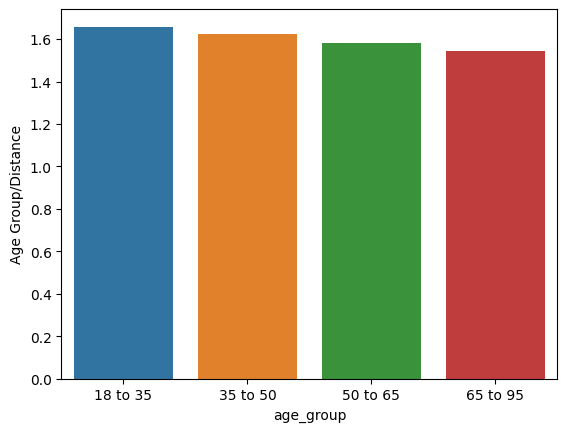

In [53]:
sn.barplot(x= pd["age_group"], y= pd['Age Group/Distance'], data=pd)
#plt.xlabel('age_group', weight = 'bold')
#plt.ylabel('haversine_distance', weight = 'bold')

In [57]:
df3_3_ng=df3_3.groupBy('age').agg(F.mean('haversine_distance').alias('Avg_Distance'))

Text(0, 0.5, 'haversine_distance')

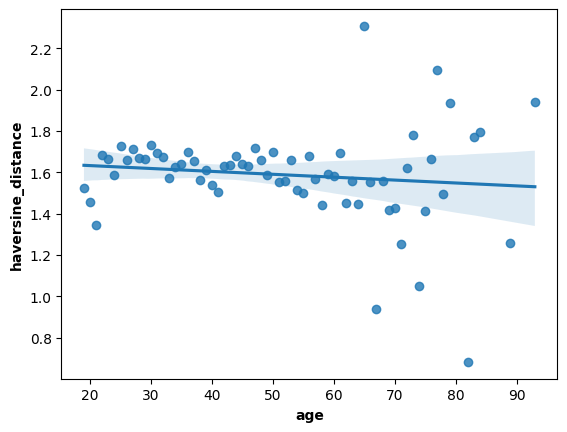

In [59]:
df2=df3_3_ng.toPandas()

sn.regplot(x= "age", y= "Avg_Distance", data=df2)
plt.xlabel('age', weight = 'bold')
plt.ylabel('haversine_distance', weight = 'bold')